## Human-compatibility analysis

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

import pandas as pd
import numpy as np
import re
import glob
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt

from policy_evaluation import evaluate_policy
from utils.policies import load_policy
from utils.config import load_config_nb
from utils.sb3.reg_ppo import RegularizedPPO
from nocturne.envs.base_env import BaseEnv

IL_COLOR = 'dodgerblue'
sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
os.environ["WANDB_NOTEBOOK_NAME"] = "human_compatible.ipynb"
PALETTE = ['#E92B2B', '#C83149', '#A63866', '#853E84', '#6444A1', '#434ABF', '#2151DC', '#0057FA']
#sns.palplot(PALETTE)

### Load dictionary that contains information about the number of intersecting paths per vehicle id

In [5]:
# Load dict with number of intersecting paths per scene
with open('../evaluation/scene_info/valid_all_01_23_11_18.pkl', 'rb') as handle:
    scene_to_paths_dict = pickle.load(handle)

# Create an empty dataframe
df_intersect = pd.DataFrame(columns=['traffic_scene', 'veh_id', 'intersecting_paths'])

# Populate the dataframe
for traffic_scene, data in scene_to_paths_dict.items():
    veh_ids = data['veh_id']
    intersecting_paths = data['intersecting_paths']

    # Repeat traffic_scene for each veh_id
    traffic_scene_col = [traffic_scene] * len(veh_ids)

    # Append to the dataframe
    df_intersect = pd.concat([df_intersect, pd.DataFrame(list(zip(traffic_scene_col, veh_ids, intersecting_paths)),
                                     columns=['traffic_scene', 'veh_id', 'intersecting_paths'])])

# Reset index
df_intersect.reset_index(drop=True, inplace=True)

### Configurations

In [23]:
# Settings
DETERMINISTIC = True 
SELECT_FROM = 10_000
NUM_EVAL_EPISODES = 10_000
CONTROLLED_AGENTS = 1 # Single agent mode
METRICS = ['goal_rate', 'off_road', 'veh_veh_collision']

TRAIN_DATA_PATH = '../data_full/train'
TEST_DATA_PATH = '../data_full/valid'

env_config = load_config_nb("env_config")
env_config.data_path = "../data_full/valid/"

# Imitation learning: load human policy
IL_BASE_PATH = "../models/il/S1000"
BC_POLICY_NAME = 'human_policy_S1000_01_12_11_11'

human_policy = load_policy(
    data_path=IL_BASE_PATH,
    file_name=BC_POLICY_NAME, 
)

# Load RL policies
HR_RL_BASE_PATH = "../models/hr_rl/ma_s1000"

# Trained policies
hr_rl_policy_paths = glob.glob(f"{HR_RL_BASE_PATH}" + "/*.zip")
hr_rl_policy_names = [os.path.basename(file)[:-4] for file in hr_rl_policy_paths]
reg_weights = []
pattern = r'L(\d+\.\d+)_S'
for string in hr_rl_policy_names:
    match = re.search(pattern, string)
    if match:
        reg_weights.append(float(match.group(1)))

### 1. Evaluate PPO, HR-PPO and IL policies in **single-agent mode**


In [7]:
# # Set data path
# env_config.data_path = "../data_full/valid/"

# df_comp_rl = pd.DataFrame()

# for model_name, reg_weight in zip(hr_rl_policy_names, reg_weights):
    
#     # Load RL policy
#     policy = RegularizedPPO.load(f"{HR_RL_BASE_PATH}/{model_name}")
    
#     # Evaluate
#     df_res = evaluate_policy(
#         env_config=env_config,
#         scene_path_mapping=scene_to_paths_dict,
#         controlled_agents=CONTROLLED_AGENTS,
#         data_path=TEST_DATA_PATH,
#         mode='policy',
#         policy=policy,
#         select_from_k_scenes=SELECT_FROM,
#         num_episodes=NUM_EVAL_EPISODES,
#     )
       
#     # Add identifiers
#     df_res['reg_weight'] = np.repeat(reg_weight, len(df_res))
#     df_res['model_name'] = np.repeat(model_name, len(df_res))

#     # Store
#     df_comp_rl = pd.concat([df_comp_rl, df_res], ignore_index=True)

In [8]:
# # Save results
#df_comp_rl.to_csv('../evaluation/results/df_compatible_rl_test_0123.csv', index=False)
#df_comp_il.to_csv('../evaluation/results/df_compatible_il_test.csv', index=False)

### 2. Alternatively, load dataframes if they already exist

In [9]:
df_comp_rl = pd.read_csv('../evaluation/results/df_compatible_rl_test_0123.csv')

In [7]:
df_comp_rl

,scene_id,veh_id,num_total_vehs,num_int_paths,goal_rate,off_road,veh_veh_collision,reg_weight,model_name
0,tfrecord-00033-of-00150_109.json,22,8,0,1.0,0.0,0.0,0.01,policy_L0.01_S1000_I605
1,tfrecord-00053-of-00150_20.json,10,8,0,1.0,0.0,0.0,0.01,policy_L0.01_S1000_I605
2,tfrecord-00031-of-00150_177.json,3,11,0,1.0,0.0,0.0,0.01,policy_L0.01_S1000_I605
3,tfrecord-00097-of-00150_114.json,12,2,0,1.0,0.0,0.0,0.01,policy_L0.01_S1000_I605
4,tfrecord-00022-of-00150_46.json,4,3,0,1.0,0.0,0.0,0.01,policy_L0.01_S1000_I605
...,...,...,...,...,...,...,...,...,...
79995,tfrecord-00006-of-00150_259.json,19,4,0,1.0,0.0,0.0,0.02,policy_L0.02_S1000_I602
79996,tfrecord-00065-of-00150_210.json,0,1,0,0.0,1.0,0.0,0.02,policy_L0.02_S1000_I602
79997,tfrecord-00075-of-00150_201.json,30,2,0,1.0,0.0,0.0,0.02,policy_L0.02_S1000_I602
79998,tfrecord-00065-of-00150_128.json,28,1,0,1.0,0.0,0.0,0.02,policy_L0.02_S1000_I602


## 3. Analyze results

In [8]:
BINS = [-1, 0, 1, 2, float('inf')]
LABELS = ['0', '1', '2', '3+']

### 3.1 Plot distribution of intersecting paths per vehicle

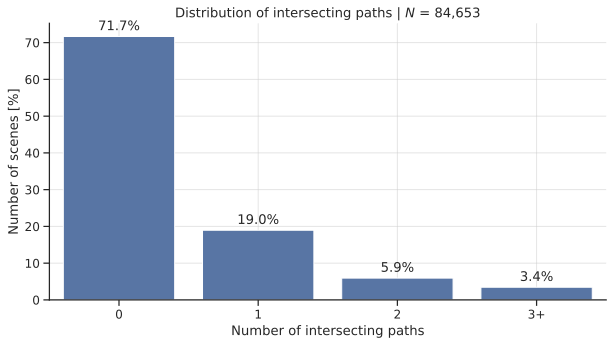

In [9]:
df = df_intersect.reset_index()
df['int_cat'] = pd.cut(df['intersecting_paths'], bins=BINS, labels=LABELS, include_lowest=True)
ax = sns.countplot(x='int_cat', data=df, stat='percent')

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title(f'Distribution of intersecting paths | $N$ = {df.index.unique().shape[0]:,}')
plt.ylabel('Number of scenes [%]')
plt.xlabel('Number of intersecting paths')
plt.grid(True, alpha=0.5)
sns.despine()

plt.savefig(f'../evaluation/figures/dist_intersecting_paths_test_set.pdf', bbox_inches="tight")


### 3.2 Plot distribution of intersecting paths per scene 

In [10]:
# Obtain the total number of intersecting paths per scene
#df_intersect.groupby('traffic_scene')['intersecting_paths'].sum()

### 3.2 Plot distribution of number of vehicles per scene

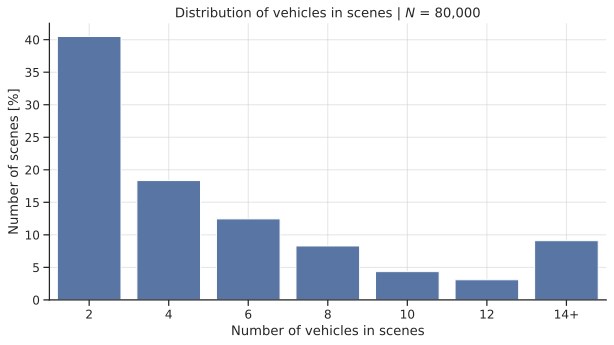

In [11]:
df = df_comp_rl.reset_index()

VEH_BINS = [2, 4, 6, 8,  10, 12, 14, float('inf')]
VEH_LABELS = ['2', '4', '6', '8', '10', '12', '14+']

df['total_vehs_cat'] = pd.cut(df['num_total_vehs'], bins=VEH_BINS, labels=VEH_LABELS, include_lowest=True)
ax = sns.countplot(x='total_vehs_cat', data=df, stat='percent')

plt.title(f'Distribution of vehicles in scenes | $N$ = {df.index.unique().shape[0]:,}')
plt.ylabel('Number of scenes [%]')
plt.xlabel('Number of vehicles in scenes')
plt.grid(True, alpha=0.5)
sns.despine()

In [12]:
# Categorize
df_comp_rl['num_total_vehs'] = df_comp_rl['num_total_vehs'].astype(int)
df_comp_rl['veh_int_paths'] = df_comp_rl['num_int_paths'].astype(int)
df_comp_rl['int_path_cat'] = pd.cut(
    df_comp_rl['num_int_paths'], bins=BINS, labels=LABELS, include_lowest=True)
df_comp_rl['total_vehs_cat'] = pd.cut(
    df_comp_rl['num_total_vehs'], bins=VEH_BINS, labels=VEH_LABELS, include_lowest=True)

# Aggregate results
df_rl_agg_comp = df_comp_rl.groupby(['reg_weight', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_rl_agg_comp['goal_rate'] = df_rl_agg_comp['goal_rate'] * 100
df_rl_agg_comp['off_road'] = df_rl_agg_comp['off_road'] * 100
df_rl_agg_comp['veh_veh_collision'] = df_rl_agg_comp['veh_veh_collision'] * 100

print(df_comp_rl.shape)
df_comp_rl.head()

(80000, 12)


,scene_id,veh_id,num_total_vehs,num_int_paths,goal_rate,off_road,veh_veh_collision,reg_weight,model_name,veh_int_paths,int_path_cat,total_vehs_cat
0,tfrecord-00033-of-00150_109.json,22,8,0,1.0,0.0,0.0,0.01,policy_L0.01_S1000_I605,0,0,6
1,tfrecord-00053-of-00150_20.json,10,8,0,1.0,0.0,0.0,0.01,policy_L0.01_S1000_I605,0,0,6
2,tfrecord-00031-of-00150_177.json,3,11,0,1.0,0.0,0.0,0.01,policy_L0.01_S1000_I605,0,0,10
3,tfrecord-00097-of-00150_114.json,12,2,0,1.0,0.0,0.0,0.01,policy_L0.01_S1000_I605,0,0,2
4,tfrecord-00022-of-00150_46.json,4,3,0,1.0,0.0,0.0,0.01,policy_L0.01_S1000_I605,0,0,2


In [13]:
# df_rl_agg_comp.style.format('{:.1f}', na_rep="")\
#     .bar(subset=['veh_veh_collision'], align=0, vmin=0, vmax=100, cmap="Reds", height=50, width=60)\
#     .set_caption("<h3>Aggregated HR-PPO collision rate with human experts</h3>").format("{:.2f}")

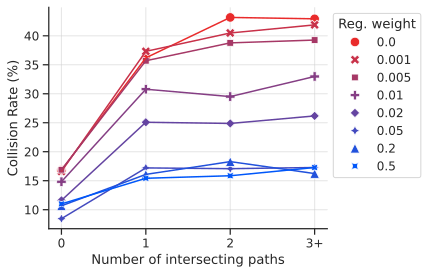

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharey=True)

# Assuming df is your DataFrame
# Reset the index to make 'reg_weight' and 'int_path_cat' regular columns
df_reset_rl = df_rl_agg_comp.reset_index()
#df_reset_il = df_il_agg_comp.reset_index()

# Convert 'reg_weight' and 'int_path_cat' to categorical
df_reset_rl['reg_weight'] = pd.Categorical(df_reset_rl['reg_weight'])
df_reset_rl['int_path_cat'] = pd.Categorical(df_reset_rl['int_path_cat'])

# HR-PPO
sns.scatterplot(x='int_path_cat', y='veh_veh_collision', data=df_reset_rl, hue='reg_weight', style='reg_weight', palette=PALETTE, marker='o', s=90, ax=ax,)
sns.lineplot(x='int_path_cat', y='veh_veh_collision', data=df_reset_rl, hue='reg_weight', palette=PALETTE, legend=False, ax=ax)

# IL
# sns.lineplot(x='int_path_cat', y='veh_veh_collision', data=df_reset_il, legend=True, c=IL_COLOR)
# sns.scatterplot(x='int_path_cat', y='veh_veh_collision', data=df_reset_il, marker='d', s=100, c=IL_COLOR, legend=True, label='BC')

# Set labels and title
ax.set_xlabel('Number of intersecting paths')
ax.set_ylabel('Collision Rate (%)')
ax.grid(True, alpha=0.5)

ax.legend(title='Reg. weight', loc='upper left', bbox_to_anchor=(1, 1))
sns.despine()

plt.savefig(f'../evaluation/figures/compatible_collision_vs_intersecting_paths.pdf', bbox_inches="tight")

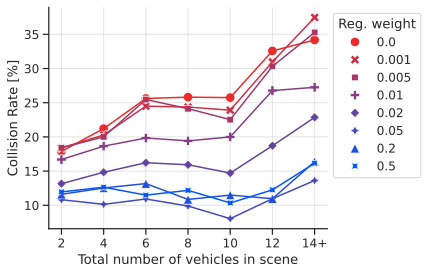

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharey=True)

df_agg_vehs = df_comp_rl.groupby(['total_vehs_cat', 'reg_weight'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean() * 100
df_reset = df_agg_vehs.reset_index()

sns.scatterplot(x='total_vehs_cat', y='veh_veh_collision', data=df_reset, hue='reg_weight', style='reg_weight', palette=PALETTE, marker='o', s=90, ax=ax)
sns.lineplot(x='total_vehs_cat', y='veh_veh_collision', data=df_reset, hue='reg_weight', palette=PALETTE, legend=False)
ax.legend(bbox_to_anchor=(1, 1), title='Reg. weight')
ax.grid(True, alpha=0.5)
sns.despine()

ax.set_ylabel('Collision Rate [%]');
ax.set_xlabel('Total number of vehicles in scene');

plt.savefig(f'../evaluation/figures/compatible_collision_vs_total_vehs_log_replay.pdf', bbox_inches="tight")

In [76]:
# Select the PPO model and the HR-PPO models with reg_weights 0.0, 0.05, 0.2
df_rl_filtered = df_reset_rl[df_reset_rl['reg_weight'].isin([0.0, 0.2, 0.05])]

In [77]:
df_rl_filtered

,reg_weight,int_path_cat,goal_rate,off_road,veh_veh_collision
0,0.00,0,79.156262,4.928374,16.809042
1,0.00,1,57.430168,7.150838,36.201117
2,0.00,2,51.707317,5.609756,43.170732
3,0.00,3+,54.973822,3.664921,42.931937
20,0.05,0,75.883822,9.659614,8.450519
21,0.05,1,62.346369,14.469274,17.206704
22,0.05,2,61.951220,12.682927,17.073171
23,0.05,3+,69.109948,7.329843,17.277487
24,0.20,0,58.825076,14.916546,10.671573
25,0.20,1,47.430168,22.513966,16.089385


In [107]:
# Subtract values from reg_weight == 0
df_diff = df_rl_filtered.copy()
df_diff[['off_road', 'veh_veh_collision']] = df_rl_filtered.groupby('int_path_cat')[['off_road', 'veh_veh_collision']].transform(lambda x: x.iloc[0] - x)
df_diff[['goal_rate']] = df_rl_filtered.groupby('int_path_cat')[['goal_rate']].transform(lambda x: x - x.iloc[0])

In [108]:
# Subtract values from reg_weight == 0
df_diff = df_rl_filtered.copy()
df_diff[['off_road', 'veh_veh_collision']] = df_rl_filtered.groupby('int_path_cat')[['off_road', 'veh_veh_collision']].transform(lambda x: x.iloc[0] - x)
df_diff[['goal_rate']] = df_rl_filtered.groupby('int_path_cat')[['goal_rate']].transform(lambda x: x - x.iloc[0])

In [113]:
df_select

,reg_weight,int_path_cat,goal_rate,off_road,veh_veh_collision
20,0.05,0,-3.272441,-4.731239,8.358523
21,0.05,1,4.916201,-7.318436,18.994413
22,0.05,2,10.243902,-7.073171,26.097561
23,0.05,3+,14.136126,-3.664921,25.654450


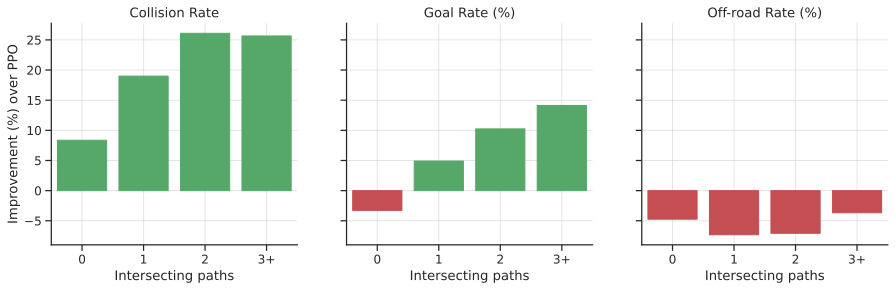

In [136]:
REG_WEIGHT = 0.05
PAL = ['g', 'r']

df_select = df_diff[df_diff['reg_weight'] == REG_WEIGHT]

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Compare to PPO
coll_colors = ['r' if c < 0 else 'g' for c in df_select['veh_veh_collision']]
sns.barplot(x='int_path_cat', y='veh_veh_collision', hue=coll_colors, data=df_select, palette=PAL, ax=axs[0], legend=False)
axs[0].set_title('Collision Rate')

# Color the bars based on the sign of off_road values
for bar, color in zip(axs[0].patches, coll_colors):
    bar.set_color(color)

goal_rate_colors = ['r' if c < 0 else 'g' for c in df_select['goal_rate']]
sns.barplot(x='int_path_cat', y='goal_rate', data=df_select, hue=goal_rate_colors, palette=PAL, ax=axs[1], legend=False)
axs[1].set_title('Goal Rate (%)')

# Color the bars based on the sign of off_road values
for bar, color in zip(axs[1].patches, goal_rate_colors):
    bar.set_color(color)

# Create a list of colors based on the sign of the off_road values
off_road_colors = ['r' if c < 0 else 'g' for c in df_select['off_road']]
sns.barplot(x='int_path_cat', y='off_road', data=df_select, hue=off_road_colors, palette=PAL, ax=axs[2], legend=False)
axs[2].set_title('Off-road Rate (%)')

# Color the bars based on the sign of off_road values
for bar, color in zip(axs[2].patches, off_road_colors):
    bar.set_color(color)

axs[0].grid(True, alpha=0.5), axs[1].grid(True, alpha=0.5), axs[2].grid(True, alpha=0.5)

axs[0].set_ylabel('Improvement (%) over PPO')
axs[0].set_xlabel('Intersecting paths')
axs[1].set_xlabel('Intersecting paths')
axs[2].set_xlabel('Intersecting paths')
sns.despine()

plt.savefig(f'../evaluation/figures/compatible_reg_{REG_WEIGHT}_to_ppo_comparison_test_set.pdf', bbox_inches="tight")

## 2. Evaluate in multi-agent (self-play) mode

In [24]:
BINS = [-1, 0, 1, 2, float('inf')]
LABELS = ['0', '1', '2', '3+']

In [33]:
# Load dataframes with results
df_self_play = pd.read_csv('../evaluation/results/df_compatible_hr_ppo_self_play_test_0124_10000.csv')
df_log_replay = pd.read_csv('../evaluation/results/df_compatible_rl_test_0123.csv')

df_self_play.shape, df_log_replay.shape

((275708, 10), (80000, 9))

In [50]:
# Group self play results
df_self_play['int_path_cat'] = pd.cut(df_self_play['veh_int_paths'], bins=BINS, labels=LABELS, include_lowest=True)
df_self_play_agg = df_self_play.groupby(['reg_weight', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_self_play_agg['goal_rate'] = df_self_play_agg['goal_rate'] * 100
df_self_play_agg['off_road'] = df_self_play_agg['off_road'] * 100
df_self_play_agg['veh_veh_collision'] = df_self_play_agg['veh_veh_collision'] * 100

# Group log replay results
df_log_replay['int_path_cat'] = pd.cut(df_log_replay['num_int_paths'], bins=BINS, labels=LABELS, include_lowest=True)
df_log_replay_agg = df_log_replay.groupby(['reg_weight', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_log_replay_agg['goal_rate'] = df_log_replay_agg['goal_rate'] * 100
df_log_replay_agg['off_road'] = df_log_replay_agg['off_road'] * 100
df_log_replay_agg['veh_veh_collision'] = df_log_replay_agg['veh_veh_collision'] * 100

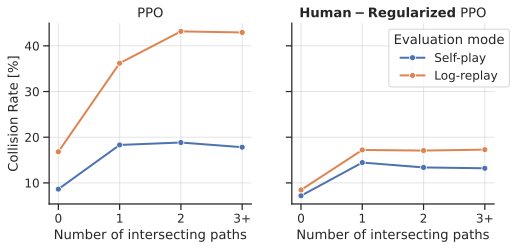

In [100]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

df_log_replay_reset = df_log_replay_agg.reset_index()
df_self_play_reset = df_self_play_agg.reset_index()

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# PPO
sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_self_play_reset[df_self_play_reset['reg_weight'] == 0.0], 
    ax=axs[0],
    marker='o',
)

sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_log_replay_reset[df_log_replay_reset['reg_weight'] == 0.0], 
    ax=axs[0],
    marker='o',
)

# HR-PPO
sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_self_play_reset[df_self_play_reset['reg_weight'] == 0.05], 
    ax=axs[1],
    marker='o',
    label='Self-play',
)

sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_log_replay_reset[df_log_replay_reset['reg_weight'] == 0.05], 
    ax=axs[1],
    marker='o',
    label='Log-replay',
)

axs[1].legend(title='Evaluation mode', loc='upper left', bbox_to_anchor=(.45, 1), facecolor='white')
axs[0].set_title('PPO')
axs[1].set_title(r'$\bf{Human - Regularized}$ PPO')
axs[0].set_ylabel('Collision Rate [%]')
axs[0].set_xlabel('Number of intersecting paths')
axs[1].set_xlabel('Number of intersecting paths')
fig.subplots_adjust(bottom=0.25)
axs[1].grid(True, alpha=0.5), axs[0].grid(True, alpha=0.5)
sns.despine()

plt.savefig(f'../evaluation/figures/coordination_self_play_vs_expert.pdf', bbox_inches="tight")

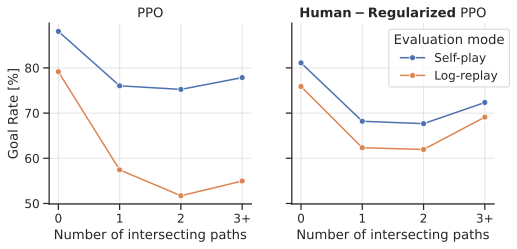

In [93]:
df_log_replay_reset = df_log_replay_agg.reset_index()
df_self_play_reset = df_self_play_agg.reset_index()

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# PPO
sns.lineplot(
    x='int_path_cat', 
    y='goal_rate', 
    data=df_self_play_reset[df_self_play_reset['reg_weight'] == 0.0], 
    ax=axs[0],
    marker='o',
)

sns.lineplot(
    x='int_path_cat', 
    y='goal_rate', 
    data=df_log_replay_reset[df_log_replay_reset['reg_weight'] == 0.0], 
    ax=axs[0],
    marker='o',
)

# HR-PPO
sns.lineplot(
    x='int_path_cat', 
    y='goal_rate', 
    data=df_self_play_reset[df_self_play_reset['reg_weight'] == 0.05], 
    ax=axs[1],
    marker='o',
    label='Self-play',
)

sns.lineplot(
    x='int_path_cat', 
    y='goal_rate', 
    data=df_log_replay_reset[df_log_replay_reset['reg_weight'] == 0.05], 
    ax=axs[1],
    marker='o',
    label='Log-replay',
)

axs[1].legend(title='Evaluation mode', loc='upper left', bbox_to_anchor=(.45, 1), facecolor='white')
axs[0].set_title('PPO')
axs[1].set_title(r'$\bf{Human - Regularized}$ PPO')
axs[0].set_ylabel('Goal Rate [%]')
axs[0].set_xlabel('Number of intersecting paths')
axs[1].set_xlabel('Number of intersecting paths')
fig.subplots_adjust(bottom=0.25)
axs[1].grid(True, alpha=0.5), axs[0].grid(True, alpha=0.5)
sns.despine()

plt.savefig(f'../evaluation/figures/coordination_self_play_vs_expert_goalrate.pdf', bbox_inches="tight")

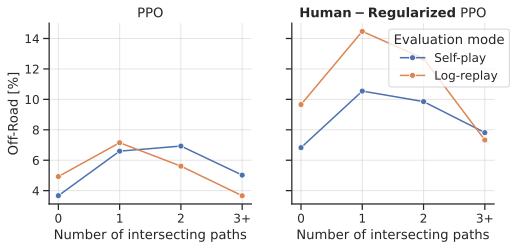

In [94]:
df_log_replay_reset = df_log_replay_agg.reset_index()
df_self_play_reset = df_self_play_agg.reset_index()

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# PPO
sns.lineplot(
    x='int_path_cat', 
    y='off_road', 
    data=df_self_play_reset[df_self_play_reset['reg_weight'] == 0.0], 
    ax=axs[0],
    marker='o',
)

sns.lineplot(
    x='int_path_cat', 
    y='off_road', 
    data=df_log_replay_reset[df_log_replay_reset['reg_weight'] == 0.0], 
    ax=axs[0],
    marker='o',
)

# HR-PPO
sns.lineplot(
    x='int_path_cat', 
    y='off_road', 
    data=df_self_play_reset[df_self_play_reset['reg_weight'] == 0.05], 
    ax=axs[1],
    marker='o',
    label='Self-play',
)

sns.lineplot(
    x='int_path_cat', 
    y='off_road', 
    data=df_log_replay_reset[df_log_replay_reset['reg_weight'] == 0.05], 
    ax=axs[1],
    marker='o',
    label='Log-replay',
)

axs[1].legend(title='Evaluation mode', loc='upper left', bbox_to_anchor=(.45, 1), facecolor='white')
axs[0].set_title('PPO')
axs[1].set_title(r'$\bf{Human - Regularized}$ PPO')
axs[0].set_ylabel('Off-Road [%]')
axs[0].set_xlabel('Number of intersecting paths')
axs[1].set_xlabel('Number of intersecting paths')
fig.subplots_adjust(bottom=0.25)
axs[1].grid(True, alpha=0.5), axs[0].grid(True, alpha=0.5)
sns.despine()

plt.savefig(f'../evaluation/figures/coordination_self_play_vs_expert_offroad.pdf', bbox_inches="tight")

In [29]:
df_self_play_agg

goal_rate   off_road  veh_veh_collision
reg_weight int_path_cat                                         
0.000      0             88.084437   3.669429           8.633239
           1             76.032083   6.597468          18.306204
           2             75.247525   6.930693          18.836030
           3+            77.854251   5.020243          17.813765
0.005      0             89.344543   3.881127           7.022319
           1             78.100181   6.503106          16.057246
           2             78.821541   7.341222          14.440956
           3+            82.388664   5.708502          12.510121
0.050      0             81.114539   6.826751           7.181596
           1             68.192184  10.544940          14.445231
           2             67.664815   9.852693          13.378411
           3+            72.348178   7.813765          13.198381
0.200      0             65.348092  10.326821           8.451783
           1             55.107337  15.255170          13.305025
           2             57.232553  14.344361          13.837237
           3+            61.781377  12.267206          12.753036